In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/saved_model.pb
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/variables/variables.index
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/variables/variables.data-00000-of-00001


## Importing the dataset

In [2]:
# Loading the files 
train_dataset = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_dataset = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_dataset.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Extracting the Required columns from the dataset

In [5]:
# Getting the text and target columns of the dataframe
train_data = train_dataset[["text", "target"]]
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_data = test_dataset[["text"]]
test_data.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# Getting the value count of each type of labels
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Spliting the train data into train and test set

In [8]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_labels, test_labels = train_test_split(train_data["text"].to_numpy(),
                                                                              train_data["target"].to_numpy(),
                                                                              test_size=0.1)
len(train_sentences), len(test_sentences), len(train_labels), len(test_labels)

(6851, 762, 6851, 762)

## Converting the Texts into numbers


In [9]:
import tensorflow_hub as hub
import tensorflow as tf
    
universal_sentence_encoder = hub.KerasLayer('https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2')

# Set the random seed 
tf.keras.utils.set_random_seed(4)

# Create a model
model = tf.keras.models.Sequential([
    universal_sentence_encoder,
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
], name="universal_sentence_encoder")

# Compile the model 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=["accuracy"])

In [10]:
# Now fit the model
history = model.fit(x=train_sentences,
                   y=train_labels,
                   epochs=100,
                   validation_data=(test_sentences, test_labels),
                   validation_steps=len(test_sentences),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience=5,
                                                               restore_best_weights=True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                  factor=0.2,
                                                                  patience=2,
                                                                  min_lr=1e-5)
                             ])

Epoch 1/100
215/215 [==============================] - 9s 27ms/step - loss: 0.5242 - accuracy: 0.7632 - val_loss: 0.4050 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 2/100
215/215 [==============================] - 5s 23ms/step - loss: 0.4302 - accuracy: 0.8205 - val_loss: 0.3895 - val_accuracy: 0.8215 - lr: 0.0010
Epoch 3/100
215/215 [==============================] - 4s 21ms/step - loss: 0.3993 - accuracy: 0.8368 - val_loss: 0.3806 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 4/100
215/215 [==============================] - 4s 19ms/step - loss: 0.3676 - accuracy: 0.8524 - val_loss: 0.3917 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 5/100
215/215 [==============================] - 4s 18ms/step - loss: 0.3188 - accuracy: 0.8733 - val_loss: 0.4193 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 6/100
215/215 [==============================] - 4s 19ms/step - loss: 0.2471 - accuracy: 0.9066 - val_loss: 0.4389 - val_accuracy: 0.8346 - lr: 2.0000e-04
Epoch 7/100
215/215 [==============================] -

## Evaluating the model on complete Validation data

In [11]:
model.evaluate(test_sentences, test_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.3806 - accuracy: 0.8399


[0.3805672526359558, 0.8398950099945068]

## Making prediction on Validation Data

In [12]:
model_pred_probs = model.predict(test_sentences)
model_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.25631174],
       [0.78821135],
       [0.09857474],
       [0.07307582],
       [0.93165064],
       [0.08283526],
       [0.64884526],
       [0.02097438],
       [0.01065053],
       [0.85442305]], dtype=float32)

In [13]:
# Getting the predictions 
model_preds = tf.round(tf.squeeze(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 1., 0., 1., 0., 0., 1.], dtype=float32)>

In [14]:
# Getting the values of different evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(y_true=test_labels,
                   y_pred=model_preds)
precision, recall, f1_score, support = precision_recall_fscore_support(y_true=test_labels,
                                                                      y_pred=model_preds,
                                                                      average="weighted")
print(f"""Accuracy: {accuracy}\n
Precision: {precision}\n
Recall: {recall}\n
F1-Score: {f1_score}\n
Support: {support}""")

Accuracy: 0.8398950131233596

Precision: 0.8397868218014599

Recall: 0.8398950131233596

F1-Score: 0.8391223417458902

Support: None


## Plot the Loss Curves

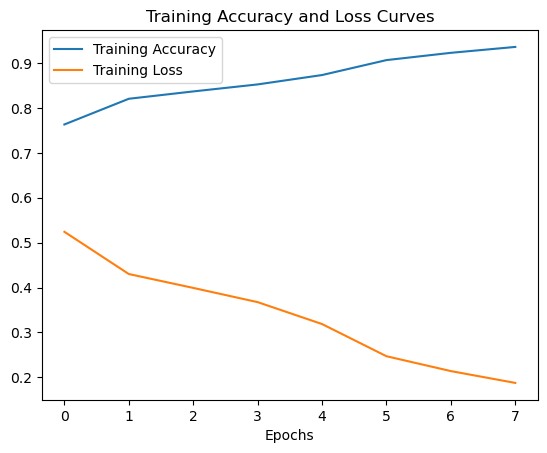

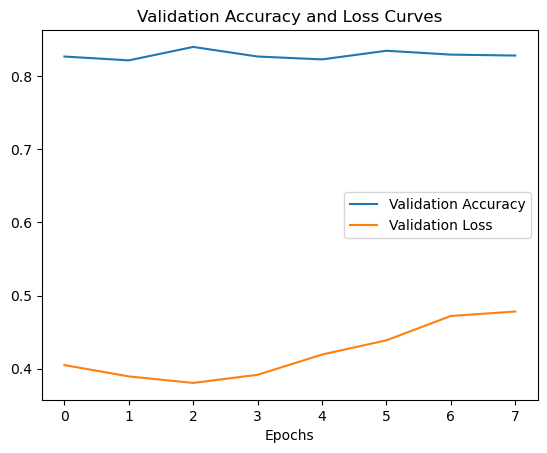

In [15]:
import matplotlib.pyplot as plt

# Getting the Training accuracy and loss values
accuracy = history.history["accuracy"]
loss = history.history["loss"]

# Getting the Validation accuracy and loss values
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(len(history.history["accuracy"]))

# Plot the loss and accuracy curves
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, loss, label="Training Loss")
plt.title("Training Accuracy and Loss Curves")
plt.xlabel("Epochs")
plt.legend()

# Plot the loss and accuracy curves of validation data
plt.figure()
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Validation Accuracy and Loss Curves")
plt.xlabel("Epochs")
plt.legend()

## Making predictions on Test Data

In [16]:
test_data

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...


In [17]:
pred_probs = model.predict(test_data["text"].to_numpy())
preds = tf.round(tf.squeeze(pred_probs))
preds

102/102 [==============================] - 1s 7ms/step


<tf.Tensor: shape=(3263,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)>

## Saving the predicted labels into the Submission file

In [18]:
preds = [int(i) for i in preds]
submission["target"] = preds
submission.to_csv('submission.csv', index=False)

In [19]:
submission[:10]


,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0
